In [ ]:
# set cwd

import os
os.chdir("/Users/neo/Projects/temple/malasim")

# run simulation in command line
os.system("./build/bin/malasim -i sample_inputs/clinical_episodes/input.yml -j 10")

# output to monthly_data_100.db


[2026-01-26 22:05:19] [info] Default logger initialized.
[2026-01-26 22:05:19] [info] Malaria Simulation v6.0.1 (branch: bonilab/malasim-v6-SURF/main, commit: f38dc5a)
[2026-01-26 22:05:19] [info] Starting...
[2026-01-26 22:05:19] [info] Parsing command line arguments
[2026-01-26 22:05:19] [info] Verbosity level set to 0. Only info will be logged.
[2026-01-26 22:05:19] [info] Loading configuration file: sample_inputs/clinical_episodes/input.yml
[2026-01-26 22:05:19] [info] Configuration file loaded successfully: sample_inputs/clinical_episodes/input.yml
[2026-01-26 22:05:19] [info] Using predefined seed number: 0
[2026-01-26 22:05:19] [info] chromosome_node: 5
[2026-01-26 22:05:19] [info] chromosome_node: 7
[2026-01-26 22:05:19] [info] chromosome_node: 13
[2026-01-26 22:05:19] [info] chromosome_node: 14
[2026-01-26 22:05:19] [info] Configuration file parsed successfully
[2026-01-26 22:05:19] [info] Validating all cross field validations
[2026-01-26 22:05:19] [info] Configuration file v

0

In [67]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

def connect_to_db(db_path):
    """Connect to the SQLite database."""
    conn = sqlite3.connect(db_path)
    return conn

def get_last_year_data(conn):
    """Extract data for the last 12 months from the database."""
    query = """
    SELECT 
        md.days_elapsed,
        msd.pfpr_all,
        msd.pfpr_2to10,
        msd.pfpr_under5,
        msd.population,
        msd.clinical_episodes,
        msd.treatments
    FROM monthly_site_data_district msd
    JOIN monthly_data md ON msd.monthly_data_id = md.id
    ORDER BY md.days_elapsed DESC
    LIMIT 12
    """
    df = pd.read_sql_query(query, conn)
    df = df.sort_values('days_elapsed')
    return df

def get_summary_statistics(df):
    """Calculate summary statistics for the last year."""
    # Annual clinical episodes per 1000 = sum(12 months) / mean(population) * 1000
    total_episodes = df['clinical_episodes'].sum()
    total_treatments = df['treatments'].sum()
    mean_population = df['population'].mean()
    annual_episodes_per_1000 = (total_episodes / mean_population) * 1000
    annual_treatments_per_1000 = (total_treatments / mean_population) * 1000
    
    return {
        'mean_pfpr_all': df['pfpr_all'].mean(),
        'mean_pfpr2to10': df['pfpr_2to10'].mean(),
        'mean_pfpr_under5': df['pfpr_under5'].mean(),
        'mean_population': mean_population,
        'total_clinical_episodes': total_episodes,
        'total_treatments': total_treatments,
        'annual_episodes_per_1000': annual_episodes_per_1000,
        'annual_treatments_per_1000': annual_treatments_per_1000
    }

def print_monthly_data(df):
    """Print monthly data in a formatted table."""
    print("\n" + "="*80)
    print("MONTHLY DATA (Last 12 months)")
    print("="*80)
    print(f"{'Day':<8} {'PfPR All':<10} {'PfPR 2-10':<10} {'PfPR <5':<10} {'Population':<12} {'Episodes':<10} {'Treatments':<10}")
    print("-"*80)
    for _, row in df.iterrows():
        print(f"{int(row['days_elapsed']):<8} {row['pfpr_all']:>9.4f} {row['pfpr_2to10']:>9.4f} "
              f"{row['pfpr_under5']:>9.4f} {int(row['population']):>11,} {int(row['clinical_episodes']):>9,} {int(row['treatments']):>9,}")
    print("="*80)

def print_summary(summary):
    """Print summary statistics."""
    print("\n" + "="*80)
    print("SUMMARY STATISTICS (Last 12 months)")
    print("="*80)
    print(f"Mean PfPR (All ages):        {summary['mean_pfpr_all']:>8.2%}")
    print(f"Mean PfPR (2-10 years):      {summary['mean_pfpr2to10']:>8.2%}")
    print(f"Mean PfPR (Under 5):         {summary['mean_pfpr_under5']:>8.2%}")
    print(f"Mean Population:             {summary['mean_population']:>11,.0f}")
    print(f"Total Clinical Episodes:     {summary['total_clinical_episodes']:>11,.0f}")
    print(f"Annual Episodes per 1000:    {summary['annual_episodes_per_1000']:>11,.1f}")
    print(f"Total Treatments:            {summary['total_treatments']:>11,.0f}")
    print(f"Annual Treatments per 1000:  {summary['annual_treatments_per_1000']:>11,.1f}")
    print("="*80 + "\n")

def plot_data(df):
    """Create visualization of the data."""
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))
    
    # Panel 1: Clinical episodes per 1000 population
    episodes_per_1000 = (df['clinical_episodes'] / df['population']) * 1000
    treatments_per_1000 = (df['treatments'] / df['population']) * 1000
    axes[0].plot(df['days_elapsed'], episodes_per_1000, marker='o', linewidth=2, markersize=6, color='#e74c3c')
    axes[0].plot(df['days_elapsed'], treatments_per_1000, linestyle='--', linewidth=2, color='#2ecc71')
    axes[0].set_xlabel('Days Elapsed')
    axes[0].set_ylabel('Episodes and Treatments per 1000')
    # add legend
    axes[0].legend(['Clinical Episodes per 1000', 'Treatments per 1000'])
    axes[0].set_title('Clinical Episodes and Treatments per 1000 Population (Monthly)', fontweight='bold', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Panel 2: PfPR by age group
    axes[1].plot(df['days_elapsed'], df['pfpr_all'], marker='o', label='All ages', linewidth=2, markersize=6)
    axes[1].plot(df['days_elapsed'], df['pfpr_2to10'], marker='s', label='2-10 years', linewidth=2, markersize=6)
    axes[1].plot(df['days_elapsed'], df['pfpr_under5'], marker='^', label='Under 5', linewidth=2, markersize=6)
    axes[1].set_xlabel('Days Elapsed')
    axes[1].set_ylabel('PfPR')
    axes[1].set_title('Parasite Prevalence Rate by Age Group', fontweight='bold', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Panel 3: Absolute clinical episodes
    axes[2].plot(df['days_elapsed'], df['clinical_episodes'], marker='o', linewidth=2, markersize=6, color='#9b59b6')
    axes[2].plot(df['days_elapsed'], df['treatments'], marker='s', linewidth=2, markersize=6, color='#3498db')
    axes[2].set_xlabel('Days Elapsed')
    axes[2].set_ylabel('Clinical Episodes / Treatments')
    axes[2].set_title('Absolute Clinical Episodes and Treatments (Monthly)', fontweight='bold', fontsize=12)
    axes[2].legend(['Clinical Episodes', 'Treatments'])
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

📊 Connecting to database: monthly_data_10.db
📈 Extracting data for last 12 months...
✅ Found 12 months of data

MONTHLY DATA (Last 12 months)
Day      PfPR All   PfPR 2-10  PfPR <5    Population   Episodes   Treatments
--------------------------------------------------------------------------------
3319       12.7225   14.2740   19.3620      61,522       389       265
3347       12.9269   14.2193   18.7553      61,609       391       273
3378       12.7297   14.1654   17.9514      61,723       381       270
3408       13.0377   14.4054   18.8842      61,822       367       262
3439       13.1654   14.7170   19.6588      61,929       361       242
3469       13.0959   14.7050   19.6459      62,059       369       256
3500       12.9350   14.5474   19.2263      62,166       379       273
3531       12.9328   14.1950   18.5038      62,285       377       270
3561       12.7480   14.1737   19.1948      62,411       351       238
3592       13.0742   14.7018   19.7856      62,529       378 

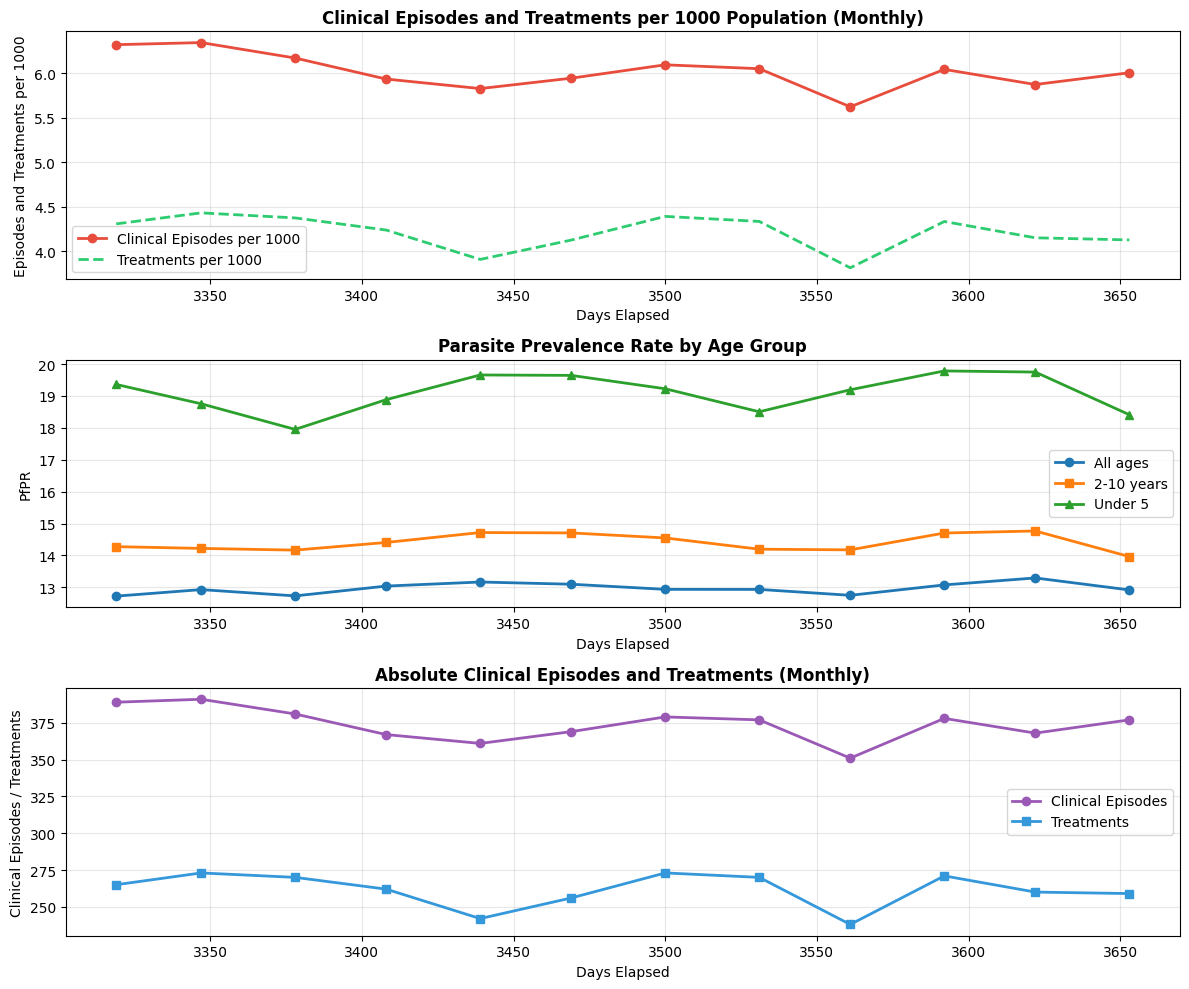


✅ Analysis complete!


In [68]:
os.chdir("/Users/neo/Projects/temple/malasim/build/bin")
db_path = "monthly_data_10.db"  

if not db_path:
    raise ValueError("Please set variable 'db_path' to the SQLite DB path before running this cell.")

try:
    print(f"📊 Connecting to database: {db_path}")
    conn = connect_to_db(db_path)

    print("📈 Extracting data for last 12 months...")
    df = get_last_year_data(conn)

    if df.empty:
        print("❌ No data found in the database")
    else:
        print(f"✅ Found {len(df)} months of data")
        summary = get_summary_statistics(df)
        print_monthly_data(df)
        print_summary(summary)

        # Always create/show plot
        plot_data(df)

    conn.close()
    print("\n✅ Analysis complete!")

except FileNotFoundError as e:
    print(f"❌ Error: {e}")
except sqlite3.Error as e:
    print(f"❌ Database error: {e}")
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    import traceback
    traceback.print_exc()
